[gluon](http://zh.gluon.ai/chapter_computer-vision/ssd.html)   [gluon](http://zh.gluon.ai/chapter_computer-vision/anchor.html)    
这是一个没有预训练模型的SSD实现，也是因为没有预训练模型，只能用来处理一些比较简单的数据集。     

如下是SSD的框架示意图   
![SSD](images/ssd.svg)   

输入图像经过一个backbone网络提取特征，然后进行若干次下采样，每个下采样层都附带一个边框预测和类别预测模块。注意和YOLOv3不同，SSD是基于backbone的输出特征图做多次下采样，这也导致SSD对小目标检测效果不好。    


In [1]:
from mxnet import contrib, image, nd,gluon,autograd, init
from mxnet.gluon import loss as gloss, nn
import mxnet as mx


C:\Users\User\Anaconda3\lib\site-packages\h5py\__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


In [54]:
num_classes = 3 #类别数目

max_obj_per_image = 1 #每幅图中目标个数最大值
obj_scales = [0.2,0.3]  #目标尺寸 wrt image 关系到anchor size的选择

anchor_sizes = [[0.175, 0.225], [0.175, 0.225], [0.275,0.325], [0.275,0.325],[0.275,0.325]]
#anchor_sizes = [[0.2, 0.272], [0.37, 0.447], [0.54, 0.619], [0.71, 0.79],[0.88, 0.961]]
anchor_ratios = [[1, 2, 0.5]] * 5

batch_size = 32

net_name = 'ssd_for_pikachu.params'

# 自动生成一个简单的集合

In [55]:
from PIL import Image,ImageDraw
import numpy as np
import random
import copy,os,pdb
from mxnet.gluon import data as gdata

img_background = Image.open('images/background.jpg')
img_sprit_1 = Image.open('images/sprits_1.jpg')
img_sprit_2 = Image.open('images/sprits_2.jpg')




outdir = 'data/temp'
if not os.path.exists(outdir):
    os.makedirs(outdir)

def random_crop(img, resize=(512,512)):
    W,H = img.size
    x0,y0,x1,y1 = random.randint(0,W//3), random.randint(0,H//3), random.randint(W*2//3, W), random.randint(H*2//3, H)
    crop = img.crop((x0,y0,x1,y1))
    #print(x0,x1,y0,y1)
    crop = crop.resize(resize)
    #crop.save('crop.jpg')
    return crop
    
    
def paste_it(background, sprit, mask):
    W,H = background.size
    W1,H1 = sprit.size
    s1 = random.randint(0,len(obj_scales) - 1)
    x1,y1,s1 = random.randint(10,W-10), random.randint(10,H-10), obj_scales[s1] * W / W1
    s1 = sprit.resize( (int(W1*s1), int(H1*s1)), Image.BILINEAR )
    if random.randint(0,2) == 0:
        s1 = s1.transpose(Image.FLIP_LEFT_RIGHT)
    x2,y2 = x1 + s1.size[0], y1 + s1.size[1]
    if x2 >= W or y2 >= H or x1 < 0 or y1 < 0:
        return background,None
    if mask[y1:y2, x1:x2].sum() > 10:
        return background,None
    mask[y1:y2,x1:x2] = 1
    result = copy.deepcopy(background)
    result.paste(s1,(x1,y1,x2,y2))
    return result,(x1/W,y1/H,x2/W,y2/H)
    
W,H = img_background.size

Xs, Ys = [], []
for num in range(512):
    mask = np.zeros((H,W))
    #img_compose = copy.deepcopy(img_background)
    img_compose = random_crop(img_background)
    Y = []
    for k in range(max_obj_per_image):
        rnd = random.randint(0,2) 
        if num_classes == 1:
            rnd = 0
        if rnd == 0:
            img_compose,sprit_1 = paste_it(img_compose,img_sprit_1,mask)
            if sprit_1 is not None:
                Y.append( (0,) + sprit_1  )
        else:
            img_compose,sprit_2 = paste_it(img_compose,img_sprit_2,mask)
            if sprit_2 is not None:
                Y.append( (1,) + sprit_2  )
                
    if len(Y) < 1:
        continue #skip image without object
    Ys.append(Y)                
    outpath = os.path.join(outdir,"%d.jpg"%num)
    Xs.append(outpath)
    img_compose.save(outpath)
    
    #显示anchor是否可以覆盖目标
    outpath = os.path.join(outdir,'%d_mark.jpg'%num)
    img_compose = img_compose.resize((256,256))
    WW,HH = img_compose.size
    draw = ImageDraw.Draw(img_compose)
    for rect in Y:
        cls, x0,y0,x1,y1 = rect
        for sizes in anchor_sizes:
            for sz in sizes:
                w,h = WW * sz, HH * sz
                cx,cy = (x1+x0)*WW / 2, (y0 + y1)*HH/2
                left,top,right,bottom = cx-w/2, cy-h/2, cx+w/2, cy+h/2
                draw.rectangle(((left,top),(right,bottom)),fill=None,outline=(255,0,0))
    img_compose.save(outpath)
    

pkchu_Ys, pkchu_Xs = [], []
with open('data/pikachu/dataset/annotations.txt','r') as f:
    for line in f:
        path,cls,x0,y0,x1,y1 = line.strip().split(' ')
        path = os.path.join('data/pikachu/dataset/images/',path)
        pkchu_Xs.append(path)
        cls,x0,y0,x1,y1 = int(float(cls)), float(x0), float(y0), float(x1), float(y1)
        Y = [ (cls,x0,y0,x1,y1)   ] #one object each image
        pkchu_Ys.append(  Y    )
        img = Image.open(path)
        W,H = img.size
        x0,y0,x1,y1 = x0*W, y0*H, x1*W, y1*H
        draw = ImageDraw.Draw(img)
        draw.rectangle(((x0,y0),(x1,y1)),0,255)
        img.save(path + ".marked.jpg")
        
#Xs,Ys = pkchu_Xs, pkchu_Ys        

    
class ToySet(gdata.Dataset):
    def __init__(self,fortrain,path_list, label_list):
        super(ToySet,self).__init__()
        self.data_list = []
        self.fortrain = fortrain
        self.resize = (256,256)
        self.max_obj_per_image = max_obj_per_image
        for path, labels in zip(path_list, label_list):
            if len(labels) < 1:
                continue
            self.data_list.append((path,labels))
        return
    def __len__(self):
        return len(self.data_list)
    
    def __getitem__(self,idx):
        path = self.data_list[idx][0]
        labels = self.data_list[idx][1]
        img = Image.open(path)
        img = img.resize(self.resize, Image.BILINEAR)
        img = np.array(img)             
        H,W,_ = img.shape
        
        if 0:
            bbox = labels[0][1:5]
            print(bbox * np.array([W,H,W,H]))
            fig = plt.imshow(img)
            rect = plt.Rectangle(xy=(bbox[0]*W, bbox[1]*H), width=bbox[2]*W-bbox[0]*W,
                             height=bbox[3]*H-bbox[1]*H, fill=False, edgecolor='r',linewidth=2)
            fig.axes.add_patch(rect)
        
        
        img = np.transpose(img,(2,0,1)).astype(np.float32) / 1.0
        img = nd.array(img)
        if len(labels) < self.max_obj_per_image: #label的第二个维度表示训练集中每个图中最大目标个数
            for k in range(self.max_obj_per_image - len(labels)):
                labels.append([-1,-1,-1,-1,-1])
        labels = np.vstack(labels)            
        labels = nd.array(labels)
        return img,labels
    

trainset = ToySet(True,Xs,Ys)
train_iter = gdata.DataLoader(trainset,batch_size,shuffle=True,last_batch="rollover")

for X,Y in train_iter:
    print(X.shape, Y.shape)
    #print(Y)
    break

(32, 3, 256, 256) (32, 1, 5)


# 自定义一个简单的Backbone网络

In [57]:

#这个下采样层既用在backbone中，也用在后续的检测模块中
def down_sample_blk(num_channels):
    blk = nn.Sequential()
    for _ in range(2):
        blk.add(nn.Conv2D(num_channels, kernel_size=3, padding=1),
                nn.BatchNorm(in_channels=num_channels),
                nn.Activation('relu'))
    blk.add(nn.MaxPool2D(2))
    return blk

#backbone
def base_net():
    blk = nn.Sequential()
    if obj_scales[0] < 0.2:
        filers_each_layer = [16, 32] #检测小目标，特征图不易太小 (错误观点:特征图太小，不容易收敛)
    else:
        filers_each_layer = [16, 32, 64]
    for num_filters in filers_each_layer:
        blk.add(down_sample_blk(num_filters))
    return blk

#完整的特征提取模块
#0： backbone
#1,2,3： 三个下采样层
#4：一个global max pool层
def get_blk(i):
    if i == 0:
        blk = base_net()
    elif i == 4:
        blk = nn.GlobalMaxPool2D()
    else:
        blk = down_sample_blk(128)
    return blk






# 定义类别预测层和边框预测层

In [58]:
#类别预测层，这里用一个卷积层实现
#其输入输出层的w/h必须一致
#输出通道数C等于(anchor个数)x(类别数+1)，这里类别不包括背景，+1就是背景类
def cls_predictor(num_anchors, num_classes):
    return nn.Conv2D(num_anchors * (num_classes + 1), kernel_size=3,
                     padding=1)


#边框预测层，也用一个卷积层实现
#输入输出的w/h必须一致
#输出通道数C等于4x(anchor个数)
def bbox_predictor(num_anchors):
    return nn.Conv2D(num_anchors * 4, kernel_size=3, padding=1)


#不同层预测出来的类别和边框的尺寸是不一样的，下面定义了一种合并方式
#每一层输出的是shape是(batch,C,H,W),不同层的输出，只有batch是一致的，其他三个值都不一样
#下面的函数把(batch,C,H,W)转换成(batch,HxWxC)
#最后在dim=1上连接
#注意mx.nd.flatten()的功能和numpy.flatten()不同，mx.nd.flatten()会保留维度0，只合并后面的维度
def flatten_pred(pred):
    return pred.transpose((0, 2, 3, 1)).flatten()

def concat_preds(preds):
    return nd.concat(*[flatten_pred(p) for p in preds], dim=1)

# 定义每个层如何预测 (SSD的重点）

In [59]:
def blk_forward(X, blk, size, ratio, cls_predictor, bbox_predictor):
    Y = blk(X) #提取特征
    anchors = contrib.ndarray.MultiBoxPrior(Y, sizes=size, ratios=ratio) #获得anchor
    cls_preds = cls_predictor(Y) #预测类别 （这不是上面定义的函数，而是其具体实现，即一个卷积层）
    bbox_preds = bbox_predictor(Y) #预测边界框 （这不是上面定义的函数，而是其具体实现，即一个卷积层）
    return (Y, anchors, cls_preds, bbox_preds)

# 定义SSD模型

In [60]:
class TinySSD(nn.Block):
    def __init__(self, num_classes, **kwargs):
        super(TinySSD, self).__init__(**kwargs)
        self.num_classes = num_classes
        
        #self.sizes = [[0.2, 0.272], [0.37, 0.447], [0.54, 0.619], [0.71, 0.79],[0.88, 0.961]]
        #self.ratios = [[1, 2, 0.5]] * 5
        # scale - 0.05, scale, scale + 0.05
        self.sizes = anchor_sizes
        self.ratios = anchor_ratios
        self.num_anchors = len(self.sizes[0]) + len(self.ratios[0]) - 1

        self.stage_0, self.stage_1, self.stage_2, self.stage_3 = nn.Sequential(),nn.Sequential(),nn.Sequential(),nn.Sequential()
        self.stage_4 = nn.Sequential()
        
        self.stage_0.add(get_blk(0), cls_predictor(self.num_anchors, self.num_classes), bbox_predictor(self.num_anchors)) #backbone
        self.stage_1.add(get_blk(1), cls_predictor(self.num_anchors, self.num_classes), bbox_predictor(self.num_anchors)) #第1个预测层
        self.stage_2.add(get_blk(2), cls_predictor(self.num_anchors, self.num_classes), bbox_predictor(self.num_anchors)) #第2个预测层
        self.stage_3.add(get_blk(3), cls_predictor(self.num_anchors, self.num_classes), bbox_predictor(self.num_anchors)) #第3个预测层
        self.stage_4.add(get_blk(4), cls_predictor(self.num_anchors, self.num_classes), bbox_predictor(self.num_anchors)) #第4个预测层 
        return
    def forward(self, X):
        anchors, cls_preds, bbox_preds = [None] * 5, [None] * 5, [None] * 5
        #print(X.shape)
        X,anchors[0], cls_preds[0], bbox_preds[0] = blk_forward(X, self.stage_0[0], self.sizes[0], self.ratios[0], self.stage_0[1], self.stage_0[2])
        #print(X.shape)
        X,anchors[1], cls_preds[1], bbox_preds[1] = blk_forward(X, self.stage_1[0], self.sizes[1], self.ratios[1], self.stage_1[1], self.stage_1[2])
        #print(X.shape)
        X,anchors[2], cls_preds[2], bbox_preds[2] = blk_forward(X, self.stage_2[0], self.sizes[2], self.ratios[2], self.stage_2[1], self.stage_2[2])
        #print(X.shape)
        X,anchors[3], cls_preds[3], bbox_preds[3] = blk_forward(X, self.stage_3[0], self.sizes[3], self.ratios[3], self.stage_3[1], self.stage_3[2])
        #print(X.shape)
        X,anchors[4], cls_preds[4], bbox_preds[4] = blk_forward(X, self.stage_4[0], self.sizes[4], self.ratios[4], self.stage_4[1], self.stage_4[2])
        # reshape函数中的0表示保持批量大小不变
        #print(X.shape)
        return (nd.concat(*anchors, dim=1),
                concat_preds(cls_preds).reshape(
                    (0, -1, self.num_classes + 1)), concat_preds(bbox_preds))
    
    
    
net = TinySSD(num_classes=num_classes)
net.initialize()
X = nd.zeros((32, 3, 256, 256))
anchors, cls_preds, bbox_preds = net(X)

print('output anchors:', anchors.shape)
print('output class preds:', cls_preds.shape)
print('output bbox preds:', bbox_preds.shape)

output anchors: (1, 5444, 4)
output class preds: (32, 5444, 4)
output bbox preds: (32, 21776)


# 定义loss和metrics

In [61]:
import pdb
cls_loss = gloss.SoftmaxCrossEntropyLoss()
bbox_loss = gloss.L1Loss()

def calc_loss(cls_preds, cls_labels, bbox_preds, bbox_labels, bbox_masks):
    cls = cls_loss(cls_preds, cls_labels)
    bbox = bbox_loss(bbox_preds * bbox_masks, bbox_labels * bbox_masks)
    return cls + bbox



def cls_eval(cls_preds, cls_labels):
    # 由于类别预测结果放在最后一维，argmax需要指定最后一维
    return (cls_preds.argmax(axis=-1) == cls_labels).sum().asscalar()

def bbox_eval(bbox_preds, bbox_labels, bbox_masks):
   # print (bbox_labels*bbox_masks)
  #  print (bbox_preds*bbox_masks).sum()
    return ((bbox_labels - bbox_preds) * bbox_masks).abs().sum().asscalar()



# 训练

In [ ]:
import time
from mxnet import lr_scheduler
ctx, net = mx.gpu(), TinySSD(num_classes=num_classes)
net.initialize(init=init.Xavier(), ctx=ctx)

#net.load_parameters(net_name)
#net.collect_params().reset_ctx(ctx)

num_epochs = 50
lr_sch = lr_scheduler.FactorScheduler(step=50, factor=0.1)
lr_sch.base_lr = 0.2
    
trainer = gluon.Trainer(net.collect_params(), 'sgd',{'wd': 5e-4})


start = time.time()
for epoch in range(num_epochs):
    acc_sum, mae_sum, n, m = 0.0, 0.0, 0, 0
    loss_hist = []
    trainer.set_learning_rate(lr_sch(epoch))
    for batch in train_iter:        
        X = batch[0].as_in_context(ctx)
        Y = batch[1].as_in_context(ctx)
        #print(X)
        #print(X.shape,Y.shape)
        with autograd.record():
            # 生成多尺度的锚框，为每个锚框预测类别和偏移量
            anchors, cls_preds, bbox_preds = net(X)
            # 为每个锚框标注类别和偏移量
            #print(cls_preds.transpose((0, 2, 1)).shape)
            bbox_labels, bbox_masks, cls_labels = contrib.nd.MultiBoxTarget(
                anchors, Y, cls_preds.transpose((0, 2, 1)))
            # 根据类别和偏移量的预测和标注值计算损失函数
            l = calc_loss(cls_preds, cls_labels, bbox_preds, bbox_labels,
                          bbox_masks)
        l.backward()
        trainer.step(batch_size)
        #nd.waitall()
        loss_hist.append( l.asnumpy()[0] / batch_size )
        acc_sum += cls_eval(cls_preds, cls_labels)
        n += cls_labels.size
        mae_sum += bbox_eval(bbox_preds, bbox_labels, bbox_masks)
        m += bbox_labels.size


    if (epoch + 1) % 10 == 0:
        loss = np.asarray(loss_hist).mean()
        print('epoch %2d, class err %.5e, bbox mae %.5e, loss %.5e, lr %.5e time %.1f sec' % (
            epoch + 1, 1 - acc_sum / n, mae_sum / m, loss, trainer.learning_rate, time.time() - start))
        start = time.time() #restart
        
        
net.save_parameters(net_name)        

epoch 10, class err 3.81039e-03, bbox mae 5.01077e-03, loss 5.67539e-04, lr 2.00000e-01 time 43.4 sec
epoch 20, class err 3.18699e-03, bbox mae 4.40541e-03, loss 4.68400e-04, lr 2.00000e-01 time 44.2 sec
epoch 30, class err 2.48426e-03, bbox mae 3.84461e-03, loss 3.72515e-04, lr 2.00000e-01 time 43.3 sec
epoch 40, class err 2.05788e-03, bbox mae 3.41437e-03, loss 3.01369e-04, lr 2.00000e-01 time 43.7 sec


In [28]:

#trainer = gluon.Trainer(net.collect_params(), 'sgd',  {'learning_rate': 0.2, 'wd': 5e-4})
def load_data_pikachu(batch_size, edge_size=256):  # edge_size：输出图像的宽和高
    data_dir = 'data/pikachu'
  #  _download_pikachu(data_dir)
    train_iter = image.ImageDetIter(
        path_imgrec=os.path.join(data_dir, 'train.rec'),
        path_imgidx=os.path.join(data_dir, 'train.idx'),
        batch_size=batch_size,
        data_shape=(3, edge_size, edge_size),  # 输出图像的形状
        shuffle=False,  # 以随机顺序读取数据集
        rand_crop=0,  # 随机裁剪的概率为1
        min_object_covered=0.95, max_attempts=200)
    val_iter = image.ImageDetIter(
        path_imgrec=os.path.join(data_dir, 'val.rec'), batch_size=batch_size,
        data_shape=(3, edge_size, edge_size), shuffle=False)
    return train_iter, val_iter

start = time.time()
train_iter, _ =  load_data_pikachu(batch_size)
for epoch in range(20):
    acc_sum, mae_sum, n, m = 0.0, 0.0, 0, 0
    train_iter.reset()  # 从头读取数据
    for batch in train_iter:
        X = batch.data[0].as_in_context(ctx)
        Y = batch.label[0].as_in_context(ctx)
        with autograd.record():
            # 生成多尺度的锚框，为每个锚框预测类别和偏移量
            anchors, cls_preds, bbox_preds = net(X)
            # 为每个锚框标注类别和偏移量
            bbox_labels, bbox_masks, cls_labels = contrib.nd.MultiBoxTarget(
                anchors, Y, cls_preds.transpose((0, 2, 1)))
            # 根据类别和偏移量的预测和标注值计算损失函数
            l = calc_loss(cls_preds, cls_labels, bbox_preds, bbox_labels,
                          bbox_masks)
        l.backward()
        trainer.step(batch_size)
        acc_sum += cls_eval(cls_preds, cls_labels)
        n += cls_labels.size
        mae_sum += bbox_eval(bbox_preds, bbox_labels, bbox_masks)
        m += bbox_labels.size

    if (epoch + 1) % 5 == 0:
        print('epoch %2d, class err %.2e, bbox mae %.2e, time %.1f sec' % (
            epoch + 1, 1 - acc_sum / n, mae_sum / m, time.time() - start))
        start = time.time()


[[[[143. 145. 149. ... 167. 165. 164.]
   [144. 146. 149. ... 169. 167. 165.]
   [145. 147. 150. ... 168. 166. 166.]
   ...
   [ 22.  33.  13. ...  37.  41.  29.]
   [ 37.  41.  39. ...  28.  13.  22.]
   [ 29.  43.  31. ...  31.  33.  20.]]

  [[144. 146. 150. ... 168. 166. 165.]
   [145. 147. 150. ... 170. 168. 166.]
   [146. 148. 151. ... 169. 167. 167.]
   ...
   [ 23.  34.  14. ...  37.  41.  29.]
   [ 38.  42.  40. ...  28.  13.  22.]
   [ 30.  44.  32. ...  31.  33.  20.]]

  [[149. 151. 155. ... 172. 170. 169.]
   [150. 152. 155. ... 174. 172. 170.]
   [151. 153. 156. ... 173. 171. 171.]
   ...
   [ 25.  36.  16. ...  37.  41.  29.]
   [ 40.  44.  42. ...  28.  13.  22.]
   [ 32.  46.  34. ...  31.  33.  20.]]]


 [[[127. 110.  85. ... 118. 147. 160.]
   [130. 113.  94. ... 128. 148. 160.]
   [131. 124. 110. ... 131. 154. 162.]
   ...
   [172. 170. 169. ... 167. 172. 168.]
   [167. 155. 156. ... 168. 160. 160.]
   [170. 170. 168. ... 169. 172. 168.]]

  [[ 77.  67.  51. ... 13


[[[[  0.   0.   1. ...   1.   0.   1.]
   [  2.   0.   0. ...   0.   0.   1.]
   [  0.   0.   1. ...   1.   1.   0.]
   ...
   [  1.   0.   0. ...   0.   0.   0.]
   [  0.   0.   1. ...   0.   0.   0.]
   [  0.   0.   0. ...   0.   0.   0.]]

  [[  0.   0.   1. ...   1.   0.   1.]
   [  2.   0.   0. ...   0.   0.   1.]
   [  0.   0.   1. ...   1.   1.   0.]
   ...
   [  1.   0.   0. ...   0.   0.   0.]
   [  0.   0.   1. ...   0.   0.   0.]
   [  0.   0.   0. ...   0.   0.   0.]]

  [[  0.   0.   1. ...   1.   0.   1.]
   [  2.   0.   0. ...   0.   0.   1.]
   [  0.   0.   1. ...   1.   1.   0.]
   ...
   [  1.   0.   0. ...   0.   0.   0.]
   [  0.   0.   1. ...   0.   0.   0.]
   [  0.   0.   0. ...   0.   0.   0.]]]


 [[[119. 121. 122. ... 231. 232. 231.]
   [118. 120. 122. ... 232. 239. 239.]
   [118. 119. 121. ... 198. 210. 209.]
   ...
   [ 78.  40.  45. ...  80.  64.  64.]
   [160.  66.  34. ...  69.  60.  58.]
   [ 63.  49. 109. ...  59.  62.  57.]]

  [[113. 114. 115. ... 20


[[[[ 83.  84.  85. ...  77.  76.  75.]
   [ 83.  84.  85. ...  77.  75.  74.]
   [ 80.  83.  85. ...  77.  74.  73.]
   ...
   [ 60.  59.  59. ...  62.  61.  59.]
   [ 61.  61.  62. ...  61.  62.  59.]
   [ 60.  63.  65. ...  63.  60.  57.]]

  [[ 86.  87.  86. ...  75.  74.  73.]
   [ 85.  86.  86. ...  75.  73.  72.]
   [ 86.  85.  86. ...  75.  72.  71.]
   ...
   [ 41.  40.  41. ...  49.  48.  45.]
   [ 42.  42.  44. ...  48.  49.  46.]
   [ 41.  44.  46. ...  50.  47.  44.]]

  [[105. 106. 106. ...  80.  79.  78.]
   [106. 107. 107. ...  80.  78.  77.]
   [105. 106. 107. ...  80.  77.  77.]
   ...
   [ 27.  26.  26. ...  33.  32.  29.]
   [ 28.  28.  30. ...  31.  33.  30.]
   [ 27.  30.  33. ...  33.  31.  28.]]]


 [[[124. 123. 124. ...  59.  59.  60.]
   [123. 123. 123. ...  59.  60.  60.]
   [123. 123. 123. ...  62.  61.  61.]
   ...
   [ 54.  47.  58. ...  75.  74.  77.]
   [ 53.  51.  55. ...  75.  75.  88.]
   [ 56.  54.  58. ...  74.  78.  75.]]

  [[147. 146. 147. ... 10


[[[[151. 146. 139. ... 100. 100. 101.]
   [103.  98. 116. ...  68.  75.  76.]
   [125. 119. 129. ... 122. 121. 121.]
   ...
   [184. 187. 189. ... 221. 222. 212.]
   [172. 173. 174. ... 218. 218. 213.]
   [156. 158. 161. ... 218. 215. 214.]]

  [[132. 130. 122. ...  90.  86.  83.]
   [ 75.  76.  90. ...  59.  62.  60.]
   [ 88.  86.  95. ... 105. 100.  94.]
   ...
   [153. 157. 157. ... 193. 194. 184.]
   [141. 142. 142. ... 190. 189. 184.]
   [127. 127. 130. ... 189. 186. 182.]]

  [[102. 109.  94. ...  88.  82.  77.]
   [ 57.  64.  71. ...  56.  62.  62.]
   [ 82.  86.  84. ...  99. 103. 108.]
   ...
   [158. 161. 160. ... 190. 191. 181.]
   [146. 147. 147. ... 186. 185. 181.]
   [132. 132. 135. ... 185. 182. 180.]]]


 [[[151. 151. 148. ...  45.  50.  48.]
   [151. 151. 148. ...  49.  48.  50.]
   [151. 151. 148. ...  50.  50.  51.]
   ...
   [146. 145. 143. ... 114. 111. 111.]
   [135. 134. 133. ... 120. 118. 116.]
   [124. 123. 124. ... 121. 121. 120.]]

  [[182. 182. 181. ... 13


[[[[203. 201. 201. ... 249. 255.  63.]
   [198. 198. 198. ... 249. 255.  63.]
   [191. 194. 195. ... 249. 255.  63.]
   ...
   [ 69.  60. 116. ... 125.  14.   0.]
   [ 70. 101.  98. ...  88.   0.  10.]
   [126.  97.  94. ...  10.  41.  14.]]

  [[215. 213. 213. ... 249. 255.  63.]
   [209. 209. 209. ... 249. 255.  63.]
   [204. 207. 208. ... 249. 255.  63.]
   ...
   [ 60.  47.  99. ... 138.  19.   3.]
   [ 58.  87.  83. ...  99.   1.  13.]
   [113.  83.  79. ...  18.  49.  19.]]

  [[231. 229. 229. ... 249. 255.  63.]
   [226. 226. 226. ... 249. 255.  63.]
   [222. 225. 226. ... 249. 255.  63.]
   ...
   [ 24.  12.  64. ...  90.  10.   1.]
   [ 23.  52.  49. ...  62.   1.  11.]
   [ 79.  48.  45. ...   2.  29.  11.]]]


 [[[250. 255. 255. ... 202. 202. 198.]
   [241. 255. 255. ... 202. 196. 198.]
   [232. 241. 255. ... 200. 199. 198.]
   ...
   [ 73.  74.  72. ... 140. 141. 138.]
   [ 72.  71.  73. ... 143. 136. 138.]
   [ 70.  71.  75. ... 142. 139. 137.]]

  [[250. 255. 255. ... 19


[[[[ 74.  74.  74. ... 194. 194. 194.]
   [ 75.  75.  75. ... 193. 194. 194.]
   [ 75.  75.  76. ... 194. 195. 195.]
   ...
   [ 87.  87.  96. ... 128. 125. 130.]
   [ 89.  90.  86. ... 125. 127. 123.]
   [ 86.  86.  86. ... 124. 119. 122.]]

  [[122. 122. 120. ... 233. 233. 233.]
   [123. 123. 122. ... 232. 233. 234.]
   [123. 123. 122. ... 233. 234. 234.]
   ...
   [ 92.  92. 100. ... 132. 129. 136.]
   [ 90.  90.  88. ... 129. 131. 129.]
   [ 86.  86.  86. ... 128. 124. 128.]]

  [[160. 160. 159. ... 250. 250. 250.]
   [161. 161. 160. ... 249. 250. 250.]
   [161. 161. 161. ... 250. 251. 251.]
   ...
   [ 91.  91. 100. ... 133. 130. 136.]
   [ 87.  88.  85. ... 130. 132. 129.]
   [ 84.  84.  84. ... 129. 125. 128.]]]


 [[[149. 154. 158. ... 102. 126.  81.]
   [149. 154. 158. ... 132.  81. 127.]
   [150. 154. 158. ... 104. 104. 142.]
   ...
   [130. 128. 132. ... 133. 120. 123.]
   [124. 129. 130. ... 122. 127. 125.]
   [128. 127. 127. ... 131. 124. 132.]]

  [[144. 141. 144. ...  9


[[[[ 99. 101. 104. ... 116. 114. 114.]
   [ 99. 102. 103. ... 114. 112. 112.]
   [ 99. 101. 105. ... 114. 112. 112.]
   ...
   [ 59.  10.  15. ...  62.  63.  61.]
   [ 56.  63.  19. ...  58.  55.  49.]
   [  4.  23.  20. ...  72.  52.  53.]]

  [[125. 128. 128. ... 138. 136. 133.]
   [125. 128. 127. ... 136. 134. 132.]
   [125. 128. 128. ... 136. 135. 132.]
   ...
   [ 64.  10.  15. ...  87.  91.  89.]
   [ 60.  66.  19. ...  80.  78.  75.]
   [ 11.  25.  22. ...  90.  73.  75.]]

  [[148. 150. 154. ... 162. 160. 158.]
   [148. 150. 153. ... 160. 158. 156.]
   [148. 150. 155. ... 160. 158. 156.]
   ...
   [ 51.   0.   6. ...  23.  28.  29.]
   [ 49.  54.   9. ...  27.  27.  27.]
   [  1.  16.  13. ...  48.  35.  40.]]]


 [[[ 16.  16.  17. ... 231. 234. 236.]
   [ 16.  16.  17. ... 233. 233. 235.]
   [ 17.  17.  17. ... 233. 235. 232.]
   ...
   [ 29.  32.  36. ... 148. 124. 115.]
   [ 35.  42.  53. ... 144. 128. 121.]
   [ 46.  53.  64. ... 145. 133. 118.]]

  [[  8.   8.   9. ... 23


[[[[100.  94.  91. ...  49.  47.  47.]
   [101. 101.  99. ...  47.  45.  45.]
   [100. 101. 102. ...  45.  44.  44.]
   ...
   [110. 120. 112. ...  86.  82.  80.]
   [108. 115. 118. ...  88.  89.  88.]
   [109. 117. 119. ...  87.  81.  86.]]

  [[ 99.  93.  89. ...  45.  42.  41.]
   [100. 100.  97. ...  43.  40.  39.]
   [ 99. 100. 101. ...  41.  39.  38.]
   ...
   [ 94. 102.  92. ...  64.  62.  61.]
   [ 93.  98.  98. ...  69.  70.  67.]
   [ 95. 101. 100. ...  69.  60.  62.]]

  [[107. 101.  97. ...  46.  41.  41.]
   [108. 108. 106. ...  43.  40.  39.]
   [108. 108. 109. ...  41.  39.  39.]
   ...
   [ 91.  99.  88. ...  59.  59.  58.]
   [ 90.  95.  94. ...  66.  66.  64.]
   [ 92.  97.  95. ...  67.  58.  60.]]]


 [[[ 79.  82.  84. ...  46.  44.  42.]
   [ 77.  80.  82. ...  44.  43.  44.]
   [ 76.  78.  81. ...  47.  46.  45.]
   ...
   [ 47.  48.  53. ...  47.  39.  40.]
   [ 46.  48.  48. ...  44.  39.  36.]
   [ 46.  47.  46. ...  44.  43.  38.]]

  [[100. 103. 105. ...  3


[[[[196. 208. 201. ... 247. 246. 246.]
   [202. 206. 203. ... 247. 244. 250.]
   [198. 197. 205. ... 249. 244. 251.]
   ...
   [ 73.  74.  75. ...  94.  90.  89.]
   [ 73.  74.  75. ...  94.  92.  90.]
   [ 74.  73.  73. ...  93.  90.  89.]]

  [[203. 216. 208. ... 247. 246. 246.]
   [209. 213. 210. ... 247. 244. 250.]
   [205. 204. 212. ... 249. 244. 251.]
   ...
   [ 73.  74.  75. ...  57.  57.  55.]
   [ 73.  74.  75. ...  57.  58.  56.]
   [ 74.  73.  73. ...  57.  56.  55.]]

  [[219. 232. 224. ... 249. 248. 248.]
   [225. 229. 226. ... 248. 246. 252.]
   [221. 220. 228. ... 249. 245. 253.]
   ...
   [ 73.  74.  75. ...  49.  47.  46.]
   [ 73.  74.  75. ...  49.  49.  48.]
   [ 74.  73.  73. ...  49.  47.  46.]]]


 [[[ 20.  21.  25. ...  47.  47.  48.]
   [ 25.  27.  27. ...  49.  48.  48.]
   [ 27.  29.  29. ...  50.  50.  47.]
   ...
   [139. 139. 140. ... 121. 123. 117.]
   [141. 140. 144. ... 119. 124. 118.]
   [141. 143. 143. ... 120. 120. 117.]]

  [[ 64.  65.  68. ...  9


[[[[173. 171. 168. ... 174. 149. 145.]
   [185. 179. 178. ... 157. 136. 144.]
   [205. 184. 200. ... 159. 151. 140.]
   ...
   [102. 105. 112. ... 111. 116. 119.]
   [ 98. 100. 102. ...  97. 118. 113.]
   [103. 106. 103. ... 121. 127. 128.]]

  [[178. 176. 173. ... 168. 145. 142.]
   [188. 181. 182. ... 151. 133. 141.]
   [207. 186. 203. ... 155. 148. 138.]
   ...
   [ 89.  92.  99. ...  90.  96.  96.]
   [ 85.  87.  89. ...  76.  97.  93.]
   [ 90.  91.  89. ... 102. 106. 107.]]

  [[198. 197. 196. ... 182. 162. 159.]
   [206. 201. 203. ... 164. 149. 161.]
   [223. 202. 221. ... 167. 166. 160.]
   ...
   [ 80.  83.  90. ...  70.  73.  74.]
   [ 76.  78.  79. ...  58.  77.  69.]
   [ 79.  80.  78. ...  85.  86.  86.]]]


 [[[207. 201. 203. ... 187. 187. 188.]
   [204. 199. 199. ... 180. 182. 187.]
   [204. 198. 200. ... 183. 182. 185.]
   ...
   [241. 232. 233. ... 116. 118. 118.]
   [236. 228. 230. ... 114. 119. 121.]
   [243. 237. 239. ... 115. 121. 128.]]

  [[190. 184. 186. ... 17


[[[[ 93.  93.  94. ... 162. 162. 161.]
   [ 94.  95.  95. ... 163. 161. 161.]
   [ 96.  95.  96. ... 162. 161. 161.]
   ...
   [ 92.  94.  72. ...  47.  51.  90.]
   [ 83.  92.  78. ... 110.  58. 129.]
   [ 85.  81.  84. ... 133.  83. 192.]]

  [[147. 147. 147. ... 173. 173. 172.]
   [147. 147. 147. ... 175. 173. 173.]
   [148. 147. 148. ... 175. 174. 174.]
   ...
   [ 80.  85.  62. ...  45.  50.  73.]
   [ 80.  89.  70. ...  95.  47. 101.]
   [ 93.  83.  80. ... 107.  61. 156.]]

  [[185. 185. 185. ... 191. 193. 192.]
   [186. 186. 186. ... 192. 191. 192.]
   [186. 186. 187. ... 192. 191. 191.]
   ...
   [ 17.  17.  18. ...  12.  31.  47.]
   [ 12.  24.  22. ...  49.  26.  60.]
   [ 19.  23.  30. ...  52.  38.  77.]]]


 [[[119. 120. 125. ... 135. 134. 133.]
   [119. 121. 125. ... 137. 136. 134.]
   [120. 123. 126. ... 140. 138. 138.]
   ...
   [172. 171. 176. ... 187. 188. 191.]
   [167. 170. 174. ... 190. 191. 195.]
   [163. 170. 171. ... 190. 191. 195.]]

  [[ 97.  98. 103. ... 12


[[[[174. 175. 178. ... 128. 147. 147.]
   [175. 176. 177. ... 132. 150. 149.]
   [176. 177. 177. ... 133. 151. 150.]
   ...
   [143. 143. 142. ... 130. 127. 123.]
   [142. 142. 141. ... 129. 128. 128.]
   [143. 142. 141. ... 126. 129. 130.]]

  [[173. 174. 175. ... 127. 146. 148.]
   [174. 175. 175. ... 131. 149. 150.]
   [175. 176. 175. ... 132. 150. 151.]
   ...
   [135. 135. 134. ...  94.  92.  89.]
   [134. 134. 133. ...  93.  94.  94.]
   [135. 134. 133. ...  92.  97. 100.]]

  [[168. 172. 177. ... 122. 141. 142.]
   [170. 173. 176. ... 126. 144. 144.]
   [170. 174. 176. ... 127. 145. 145.]
   ...
   [133. 133. 132. ...  82.  80.  77.]
   [132. 132. 131. ...  81.  82.  82.]
   [133. 132. 131. ...  80.  84.  86.]]]


 [[[  2.   3.   4. ...  57.  75.  81.]
   [  2.   2.   4. ...  60.  69.  72.]
   [  2.   3.   3. ...  63.  65.  75.]
   ...
   [ 63. 102. 129. ... 149. 159. 172.]
   [ 62. 120. 134. ... 140. 152. 168.]
   [ 87. 131. 135. ... 136. 147. 161.]]

  [[  0.   1.   3. ...  3


[[[[103. 107.  98. ...  65.  77.  34.]
   [ 95. 107. 101. ...  63.  78.  34.]
   [ 96. 105. 103. ...  63.  78.  33.]
   ...
   [ 27.  27.  28. ...  34.  34.  32.]
   [ 28.  26.  27. ...  32.  32.  33.]
   [ 28.  25.  24. ...  30.  30.  30.]]

  [[105. 108.  98. ...  80.  93.  40.]
   [100. 108. 101. ...  79.  94.  38.]
   [100. 108. 104. ...  79.  92.  37.]
   ...
   [ 41.  41.  44. ...  46.  46.  44.]
   [ 44.  42.  43. ...  44.  44.  45.]
   [ 44.  41.  40. ...  42.  43.  43.]]

  [[109. 111. 100. ...  89. 105.  56.]
   [100. 110. 102. ...  88. 105.  55.]
   [101. 108. 104. ...  88. 104.  54.]
   ...
   [ 54.  54.  59. ...  60.  60.  58.]
   [ 57.  55.  58. ...  58.  58.  59.]
   [ 57.  54.  55. ...  56.  56.  56.]]]


 [[[123. 123. 125. ... 171. 169. 169.]
   [123. 124. 127. ... 171. 168. 166.]
   [126. 126. 128. ... 171. 164. 170.]
   ...
   [116. 114. 114. ... 117. 111. 107.]
   [113. 112. 111. ... 112. 104. 103.]
   [110. 109. 108. ... 106. 109. 101.]]

  [[122. 122. 124. ... 16

KeyboardInterrupt: 

# 预测

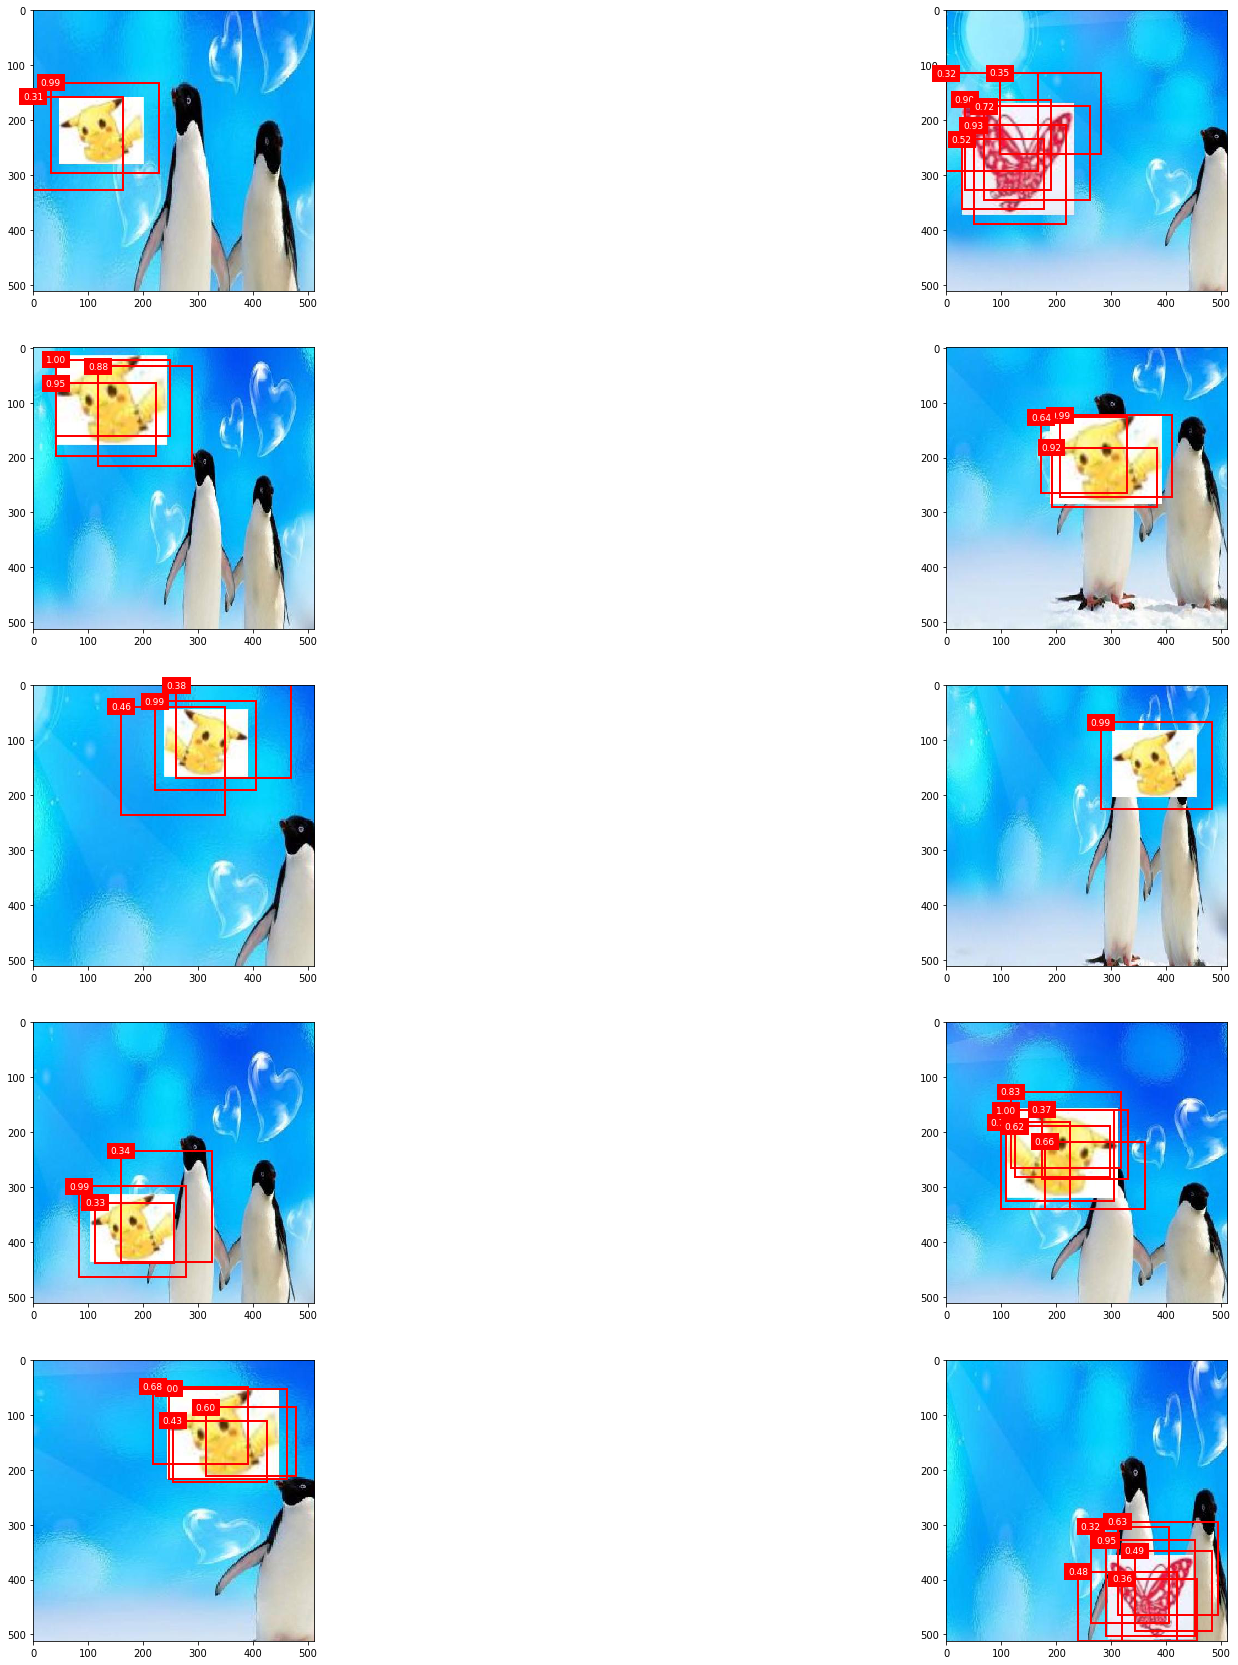

In [53]:
%matplotlib inline
import matplotlib.pyplot as plt

def predict(X):
    anchors, cls_preds, bbox_preds = net(X.as_in_context(ctx))
    #print(bbox_preds)
    cls_probs = cls_preds.softmax().transpose((0, 2, 1))
    output = contrib.nd.MultiBoxDetection(cls_probs, bbox_preds, anchors)
    idx = [i for i, row in enumerate(output[0]) if row[0].asscalar() != -1]
    if len(idx) < 1:
        return None
    return output[0, idx]

def bbox_to_rect(bbox, color):
    """Convert bounding box to matplotlib format."""
    return plt.Rectangle(xy=(bbox[0], bbox[1]), width=bbox[2]-bbox[0],
                         height=bbox[3]-bbox[1], fill=False, edgecolor=color,linewidth=2)

def _make_list(obj, default_values=None):
    if obj is None:
        obj = default_values
    elif not isinstance(obj, (list, tuple)):
        obj = [obj]
    return obj

def show_bboxes(axes, bboxes, labels=None, colors=None):
    """Show bounding boxes."""
    labels = _make_list(labels)
    colors = _make_list(colors, ['b', 'g', 'r', 'm', 'k'])
    for i, bbox in enumerate(bboxes):
        color = colors[i % len(colors)]
        rect = bbox_to_rect(bbox.asnumpy(), color)
        axes.add_patch(rect)
        if labels and len(labels) > i:
            text_color = 'k' if color == 'w' else 'w'
            axes.text(rect.xy[0], rect.xy[1], labels[i],
                      va='center', ha='center', fontsize=9, color=text_color,bbox=dict(facecolor=color, lw=0))

def display(fig,img, output, threshold):
    fig.imshow(img.asnumpy())
    for row in output:
        score = row[1].asscalar()
        if score < threshold:
            #print('skip obj with low score:',row)
            continue
        h, w = img.shape[0:2]
        bbox = [row[2:6] * nd.array((w, h, w, h), ctx=row.context)]
        #print(bbox)
        show_bboxes(fig.axes, bbox, '%.2f' % score, 'r')


plt.figure(figsize=(30,30))
for ind in range(0,10):
    fig = plt.subplot(5,2,ind+1)
    if isinstance(train_iter, mx.image.ImageDetIter):
        img = image.imread('data/pikachu/pikachu.jpg')
    else:
        img = image.imread(Xs[ind*5])
    feature = image.imresize(img, 256, 256).astype('float32') / 1.0
    X = feature.transpose((2, 0, 1)).expand_dims(axis=0)        
    

    output = predict(X)


    if output is not None:
        display(fig,img, output, threshold=0.3)
    else:
        print('no-obj found')